<a href="https://colab.research.google.com/github/tztechno/cc_archive/blob/main/colab_gaussian_splatting_v4_w_pycolmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Splatting w/PyCOLMAP

In [ ]:
!pip install imageio-ffmpeg
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 95.7 MB/s eta 0:00:00


In [ ]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pycolmap
from pathlib import Path
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

recon = pycolmap.Reconstruction('/content/drive/MyDrive/your_folder/sparse/0')
image_dir = Path('/content/drive/MyDrive/your_folder/images/')

Mounted at /content/drive


In [ ]:
#### NEW2025

all_images = []
all_poses = []
all_intrinsics = []

for image_id, image in recon.images.items():
    # Load image
    img_path = image_dir / image.name
    img_pil = Image.open(img_path)
    #img_resized = img_pil.resize((800,600), Image.LANCZOS)
    img = np.array(img_pil) / 255.0
    all_images.append(img)

    # Intrinsic matrix
    cam = recon.cameras[image.camera_id]
    fx, fy = cam.params[0], cam.params[1]
    cx, cy = cam.params[2], cam.params[3]
    intrinsics = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ])
    all_intrinsics.append(intrinsics)

    # Get camera pose (world-to-camera transformation)
    cam_fromworld = image.cam_from_world()

    # Extract rotation and translation
    R = cam_fromworld.rotation.matrix()  # Rotation matrix (3x3)
    t = cam_fromworld.translation        # Translation vector (3,)

    # Convert to camera-to-world (invert the transformation)
    c2w = np.eye(4)
    c2w[:3, :3] = R.T              # Transpose of rotation
    c2w[:3, 3] = -R.T @ t          # New translation
    all_poses.append(c2w)

print(len(all_images))


images = np.stack(all_images)
poses = np.stack(all_poses)
intrinsics = np.stack(all_intrinsics)

print('images.shape:', images.shape)
print('poses.shape:', poses.shape)

H, W = images.shape[1:3]
print('Image dimensions (H, W):', H, W)

# Extract camera positions
camera_positions = poses[:, :3, 3]
print("First 3 camera positions:")
print(camera_positions[0:3])

camera_rotations = poses[:, :3, :3]  # Shape: (N, 3, 3)
camera_directions = -camera_rotations[:, :, 2]  # Shape: (N, 3)
radius = np.linalg.norm(camera_positions, axis=1)
print("Camera distances from origin:")
print(radius)

106
images.shape: (106, 900, 1600, 3)
poses.shape: (106, 4, 4)
Image dimensions (H, W): 900 1600
First 3 camera positions:
[[ 1.02655963  2.00588797 -1.24172693]
 [-1.34045007 -2.4819018   1.56071229]
 [-0.90577595 -0.7060985   0.36872191]]
Camera distances from origin:
[2.57279944 3.22373476 1.20621765 2.00812388 6.05815667 5.94368583
 5.81891762 5.70570455 5.59667872 5.49642761 5.39758197 5.29618394
 5.18997304 5.07488521 4.83003158 4.95248115 4.71962257 4.62077517
 4.52248502 4.41348079 4.30598578 4.19579707 4.08507139 3.83814414
 3.96666255 3.72236198 3.61471449 3.50642627 3.17580972 3.4033098
 3.28915458 2.8428521  3.06892108 2.95868385 2.75920967 2.67022618
 2.24749663 2.46794899 2.3591503  2.1334154  1.91185533 1.82351167
 1.72623759 1.49675623 1.61708996 1.38279311 1.27604008 2.96143443
 3.08928579 3.45435493 3.56857289 3.68916429 3.81122562 3.93429325
 4.06001129 4.19198513 4.34898157 4.47341246 4.59770791 4.72119002
 4.84991312 2.83662409 6.56708179 1.08036697 4.98391512 6.27

In [ ]:
#### NEW2025
# Get any image
sample_image = next(iter(recon.images.values()))
camera = recon.cameras[sample_image.camera_id]

# Get camera model information correctly
camera_model = camera.model  # This returns the model type directly
print('Camera model:', camera_model)
print('Camera parameters:', camera.params)

# Extract focal length depending on model
if camera_model == 'SIMPLE_PINHOLE':
    focal = camera.params[0]       # [f, cx, cy]
elif camera_model == 'PINHOLE':
    fx = camera.params[0]          # [fx, fy, cx, cy]
    fy = camera.params[1]
    focal = (fx + fy) / 2
elif camera_model == 'SIMPLE_RADIAL':
    focal = camera.params[0]       # [f, cx, cy, k]
elif camera_model == 'RADIAL':
    focal = camera.params[0]       # [f, cx, cy, k1, k2]
elif camera_model == 'OPENCV':
    fx = camera.params[0]          # [fx, fy, cx, cy, k1, k2, p1, p2]
    fy = camera.params[1]
    focal = (fx + fy) / 2
elif camera_model == 'OPENCV_FISHEYE':
    fx = camera.params[0]          # [fx, fy, cx, cy, k1, k2, k3, k4]
    fy = camera.params[1]
    focal = (fx + fy) / 2
else:
    # For unknown models, assume first parameter is focal length
    print(f"Warning: Unknown camera model {camera_model}, assuming first parameter is focal length")
    focal = camera.params[0]

print('Focal length:', focal)

Camera model: CameraModelId.SIMPLE_RADIAL
Camera parameters: [1.46455676e+03 8.00000000e+02 4.50000000e+02 3.42409887e-02]
Focal length: 1464.5567559575632


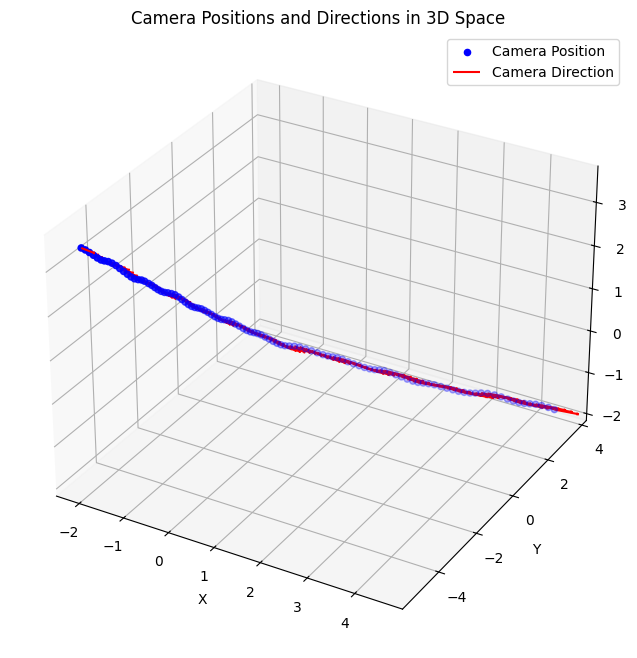

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    camera_positions[:, 0],
    camera_positions[:, 1],
    camera_positions[:, 2],
    c='blue',
    label='Camera Position'
)

for i in range(len(poses)):
    ax.quiver(
        camera_positions[i, 0],  # point(x)
        camera_positions[i, 1],  # point(y)
        camera_positions[i, 2],  # point(z)
        camera_directions[i, 0],  # vector(x)
        camera_directions[i, 1],  # vector(y)
        camera_directions[i, 2],  # vector(z)
        color='red',
        length=0.5,
        arrow_length_ratio=0.1,
        label='Camera Direction' if i == 0 else None
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Camera Positions and Directions in 3D Space')
plt.show()

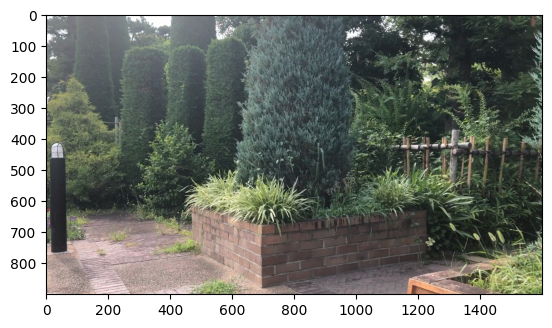

In [ ]:
testimg, testpose = images[10], poses[10]
plt.imshow(testimg)
plt.show()

In [ ]:
images = images[:100,...,:3] #images[:100, :, :, :3]
poses = poses[:100]

(4, 4)
[ 2.57180779 -0.07459232  4.74490587]


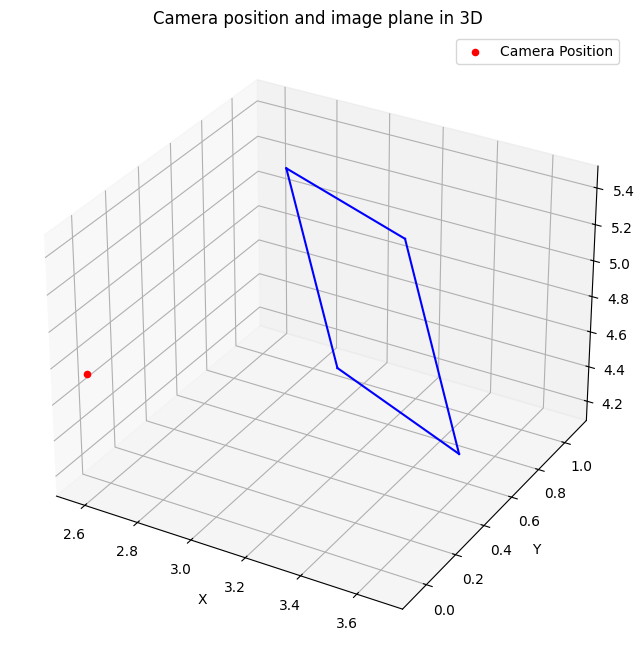

In [ ]:
print(testpose.shape)

# Compute camera position (world coordinates)
camera_to_world = np.linalg.inv(testpose)
cam_pos = camera_to_world[:3,3]
print(cam_pos)

# Define image plane corners in camera coordinates
f = 1.0  # focal length (distance along Z)
img_width = 1.0
img_height = 1.0

corners_cam = np.array([
    [-img_width/2, -img_height/2, f, 1],
    [ img_width/2, -img_height/2, f, 1],
    [ img_width/2,  img_height/2, f, 1],
    [-img_width/2,  img_height/2, f, 1],
]).T  # shape (4,4)

# Transform image plane corners to world coordinates
corners_world = camera_to_world @ corners_cam
corners_world = corners_world[:3, :].T  # shape (4,3)

# Plotting
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot camera position
ax.scatter(*cam_pos, color='red', label='Camera Position')

# Plot image plane edges
for i in range(4):
    start = corners_world[i]
    end = corners_world[(i+1) % 4]
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 'b-')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Camera position and image plane in 3D')

ax.legend()
plt.show()


---

## 🔧 Optimize NeRF

In [ ]:
#### NEW 2025-07-06

def posenc(x, L_embed=6):
    rets = [x]
    for i in range(L_embed):
        freq = 2.**i
        sin_val = tf.sin(freq * x)
        cos_val = tf.cos(freq * x)
        rets.extend([sin_val, cos_val])
    return tf.concat(rets, -1)


L_embed = 6
embed_fn = posenc
#def init_model(D=8, W=256, L_embed=6):
def init_model(D=16, W=512, L_embed=6):
    # 活性化関数の選択
    relu = tf.keras.layers.ReLU()
    # Swish活性化関数も試す価値あり
    # from tensorflow.keras.activations import swish
    # act = swish

    input_shape = (3 + 3*2*L_embed,)
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Batch Normalizationの追加
    for i in range(D):
        x = tf.keras.layers.Dense(W)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = relu(x)

        # Skip connectionの改良
        if i % 4 == 0 and i > 0:
            x = tf.keras.layers.Concatenate()([x, inputs])

    # 出力層
    outputs = tf.keras.layers.Dense(4, activation=None)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # 学習率スケジューリング
    # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    # model.compile(optimizer=optimizer, ...)

    return model

model = init_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     20,480 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 512)       │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ re_lu[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    262,656 │ re_lu[2][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    262,656 │ re_lu[3][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 551)       │          0 │ re_lu[4][0],      │
│ (Concatenate)       │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    282,624 │ concatenate[0][0

 Total params: 4,055,044 (15.47 MB)

 Trainable params: 4,038,660 (15.41 MB)

 Non-trainable params: 16,384 (64.00 KB)

In [ ]:
def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*1):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

## 🔧 Interactive Visualization

In [ ]:
print(H,W)

900 1600


In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
from IPython.display import clear_output

trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    clear_output(wait=True)
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4]) # H2,W2 >1000
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=4)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [5., 3., 8.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

## 🔧 Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 18, endpoint=False)):
    c2w = pose_spherical(th, -30., 5.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=4)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=4, quality=10)

from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/tmp/ipython-input-14-2683325868.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 18, endpoint=False)):


  0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 